In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, shape, Point
import pyproj
from functools import partial
from shapely.ops import transform
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn import neural_network
from scipy import stats


%matplotlib inline

In [3]:
#tabela de volumes por par de equipamentos
od_vol = pd.read_csv('cost_paths_cars.csv').drop(columns = ['Unnamed: 0', 'row_id']).rename(columns = {'cat1':'vol'})
od_vol = od_vol.dropna(how = 'all')

#tabela de localização de cada equipamento
equips_map = gpd.read_file('../pacote_USP/equips.shp')

#tabela com geometria de zonas de são paulo
sp_zones = gpd.read_file('../Shape/Zonas_2017_region.shp')
sp_zones = sp_zones[sp_zones.NomeMunici == 'São Paulo']
sp_zones.crs = {'init': 'epsg:22523'}
sp_zones = sp_zones.to_crs({'init': 'epsg:4326'})
                    
#tabela com a zona de cada equipamento                                      
equips_within_zones = gpd.sjoin(equips_map, sp_zones, how="inner", op='intersects')
equips_within_zones = equips_within_zones[['id','geometry','NumeroZona']]
                    
#tabela com os volumes para cada par de equipamento com a zona do equipamento de destino                    
vol_within_zones = pd.merge(od_vol,equips_within_zones, how = 'inner', left_on = 'last', \
                         right_on = 'id', right_index = False, left_index = False)
vol_within_zones = vol_within_zones.rename(columns = { 'first':'fid', \
                                                'last':'lid','cat1':'vol', \
                                                'NumeroZona':'lzone'})

vol_within_zones = pd.merge(vol_within_zones,equips_within_zones[['id','NumeroZona']], how = 'inner', left_on = 'fid', \
                         right_on = 'id', right_index = False, left_index = False)
vol_within_zones = vol_within_zones.rename(columns = {'NumeroZona':'fzone'})[['fid','lid','vol','fzone','lzone','cost_f']]


                    
#tabela da pesquisa od                    
od_survey = pd.read_csv('../pesquisa_OD.csv', sep =';').dropna(how = 'all').replace('-',0)


vol_within_zones_data = pd.merge(vol_within_zones,od_survey, how = 'inner', left_on = 'lzone', \
                         right_on = 'zona', right_index = False, left_index = False
                        )
vol_within_zones_data = pd.merge(vol_within_zones_data,od_survey[['zona']], how = 'inner', left_on = 'fzone', \
                         right_on = 'zona', right_index = False, left_index = False
                        )


In [4]:
equips_map.head()

,id2,id,dscrptn,sentido,x,y,geometry
0,10000,10000,"Sao Paulo - R Domingos De Morais, 2.329 - Sent...",centro,-46.63649,-23.59656,POINT (-46.63649 -23.59655999999921)
1,10001,10001,Itapecerica Da Serra - Sp-228 - Km 29 + 200 - ...,leste,-46.82645,-23.69856,POINT (-46.82644999999999 -23.69855999999919)
2,10003,10003,Itupeva - Sp-300 - Rod Dom Gabriel Paulimo Bue...,leste,-47.04259,-23.23534,POINT (-47.04258999999999 -23.23533999999919)
3,10006,10006,Sao Paulo - Av Nove De Julho X R Paim - Sent A...,None,-46.64875,-23.55459,POINT (-46.64874999999999 -23.55458999999921)
4,10007,10007,"Taboao Da Serra - Est Kizaemon Takeuti, 286 - ...",bairro,-46.78032,-23.63451,POINT (-46.78031999999998 -23.63450999999921)


In [5]:
#planilha de pares com volumes faltantes
od_vol_missing = vol_within_zones_data[vol_within_zones_data.vol == 0].drop(columns = ['lzone','fzone','zona_x','zona_y','nome','municipio'])
od_vol_missing.fid.unique()

array([10146, 10013, 11486, 13672, 10021, 12201, 10027, 10033, 11099,
       11234, 11634, 10298, 10035, 10074, 10036, 10724, 10037, 10456,
       10054, 11085, 10101, 10443, 12935, 10071, 10081, 10090, 10124,
       10700, 10232, 11022, 10147, 11030, 10917, 10149, 10218, 10152,
       10155, 10165, 11172, 10167, 10515, 11625, 11007, 12067, 10172,
       11459, 10190, 10194, 12332, 10195, 10196, 10550, 10204, 10761,
       14339, 11025, 10211, 12137, 11239, 10239, 10979, 11318, 10256,
       11306, 10271, 13154, 10274, 10276, 11487, 10279, 10328, 10363,
       10725, 12407, 12525, 13124, 14120, 10937, 10372, 13480, 12006,
       12271, 10383, 10584, 10867, 10408, 10418, 10985, 13733, 10455,
       12582, 10460, 11530, 10544, 10922, 11123, 10478, 11069, 10484,
       10487, 10523, 10536, 10840, 12373, 13909, 10540, 10542, 10553,
       10559, 10576, 10580, 10583, 10618, 10844, 10624, 11036, 10631,
       10649, 11449, 12529, 11521, 10656, 12377, 11776, 12225, 14245,
       12787, 12258,

In [6]:
#planilha de pares com volumes presentes
od_vol_filled = vol_within_zones_data[vol_within_zones_data.vol > 0].drop(columns = ['lzone','fzone','zona_x','zona_y','nome','municipio'])
od_vol_filled.head()

,fid,lid,vol,cost_f,domicilios,familias,populacao,matriculas,empregos,automoveis,...,atr_motivo_trabalho_industria,atr_motivo_trabalho_comercio,atr_motivo_trabalho_servcos,atr_motivo_educacao,atr_motivo_compras,atr_motivo_saude,atr_motivo_lazer,atr_motivo_procurar_emprego,atr_motivo_assuntos_pessoais,atr_motivo_refeicao
0,10000,10006,6.500,0.34,7996.0,7996.0,18401.0,4010.2,12141.9,2582.2,...,1956.8,1345.7,19550.9,11491.3,1789.2,656.5,1842.3,0.0,1305.0,891.8
1,10146,10006,4.667,0.32,7996.0,7996.0,18401.0,4010.2,12141.9,2582.2,...,1956.8,1345.7,19550.9,11491.3,1789.2,656.5,1842.3,0.0,1305.0,891.8
2,10000,10165,4.200,0.28,6836.0,6836.0,14277.0,1979.1,12564.2,7612.0,...,1391.3,5000.3,18861.1,6241.9,3973.8,2079.7,2159.0,0.0,1728.9,1108.9
3,10000,11172,5.467,0.30,6836.0,6836.0,14277.0,1979.1,12564.2,7612.0,...,1391.3,5000.3,18861.1,6241.9,3973.8,2079.7,2159.0,0.0,1728.9,1108.9
4,10146,10165,4.500,0.32,6836.0,6836.0,14277.0,1979.1,12564.2,7612.0,...,1391.3,5000.3,18861.1,6241.9,3973.8,2079.7,2159.0,0.0,1728.9,1108.9


In [7]:
def get_corr_feats(df, n):
    
    df = df.drop(columns = ['fid','lid'])
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df[df.vol > 0]
    
    corr = df.corr()
    corr_cols = list(corr['vol'].apply(lambda x : x if x > 0 else -x).sort_values(ascending=False)[1:n+1].index)
    
    return corr_cols

In [8]:
def tukey_rule(data_frame, column_name):
    data_frame['feat'] = data_frame[column_name].apply(lambda x: np.log10(x))
    data = data_frame['feat']
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    IQR = Q3 - Q1

    max_value = Q3 + 1.5 * IQR
    min_value = Q1 - 1.5 * IQR
    
    return data_frame[(data_frame['feat'] < max_value) & (data_frame['feat'] > min_value)].drop(columns=['feat'])


In [9]:
def zscore_rule(data_frame, column_name, n):
    data_frame["zscore"] = stats.zscore(data_frame[column_name])
    data_frame["is_outlier"] = data_frame["zscore"].apply(lambda x: x <= -n or x >= n)
    
    return data_frame[data_frame["is_outlier"]].drop(columns = ["is_outlier","zscore"])
    



In [10]:
def draw_learning_curves(X, y, estimator, num_trainings):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, num_trainings))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.plot(train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(test_scores_mean, 'o-', color="y",
             label="Cross-validation score")


    plt.legend(loc="best")

    plt.show()

In [11]:
# removing outliers

equip_id = 10443
n_feats = 10

od_vol_filled_by_equip = od_vol_filled[od_vol_filled.fid == equip_id]
od_vol_missing_by_equip = od_vol_missing[od_vol_missing.fid == equip_id]

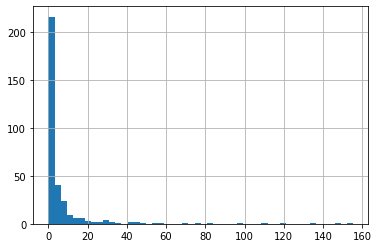

In [12]:
od_vol_filled_by_equip['vol'].hist(bins = 50);

C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


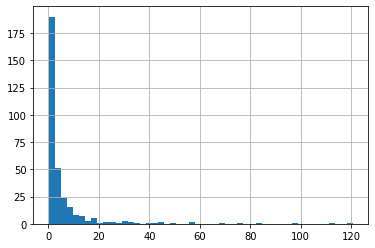

In [13]:
od_vol_filled_by_equip = tukey_rule(od_vol_filled_by_equip, 'vol')
od_vol_filled_by_equip.loc[:,'vol'].hist(bins = 50);

In [14]:
# sampling

corr_feats = get_corr_feats(od_vol_filled_by_equip, n_feats)

print('Most pearson correlated features:',corr_feats)

X = od_vol_filled_by_equip[corr_feats]
y = od_vol_filled_by_equip[['vol']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)


od_vol_missing_by_equip

Most pearson correlated features: ['cost_f', ' atr_outros ', 'prod_outros', 'prod_dirigindo_moto', 'emprego_serviço_crediticios_financeiros', 'emprego_serviço_especializado', ' atr_dirigindo_moto ', 'prod_motivo_lazer', 'emprego_serviço_alimentacao', ' emprego_setor_terciario ']


,fid,lid,vol,cost_f,domicilios,familias,populacao,matriculas,empregos,automoveis,...,atr_motivo_trabalho_industria,atr_motivo_trabalho_comercio,atr_motivo_trabalho_servcos,atr_motivo_educacao,atr_motivo_compras,atr_motivo_saude,atr_motivo_lazer,atr_motivo_procurar_emprego,atr_motivo_assuntos_pessoais,atr_motivo_refeicao
9190,10443,12011,0.0,0.54,14938.0,14938.0,39440.0,8489.5,20774.8,17032.5,...,4522.5,14550.0,22238.7,25938.5,3117.6,2032.5,6557.6,281.8,1799.4,1240.6
9837,10443,11137,0.0,1.45,21512.0,21512.0,70826.0,15195.5,17140.3,7552.9,...,6983.8,8127.1,29098.4,45352.7,3549.9,7641.5,847.7,465.2,2650.3,646.5


model:  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
r2_score:  -0.11679802410886042


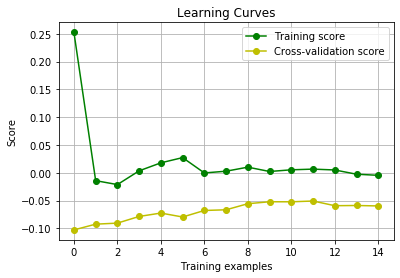

_________________________________________________________________


model:  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
r2_score:  -0.11523594969442885


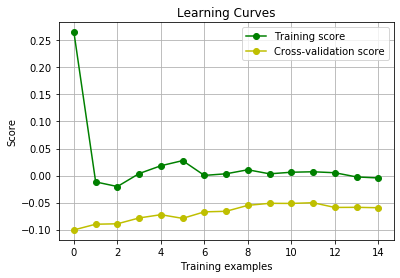

_________________________________________________________________


model:  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
r2_score:  -50.57937336314023


In [ ]:
# svr REGRESSION

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# modeling
classifiers = [
    svm.SVR(gamma='auto'),
    svm.SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
    #svm.SVR(kernel='linear', gamma='auto'),
    #svm.SVR(kernel= 'poly', C= 1e3, degree= 2, gamma ='auto')
    
    ]

trainingData    = X_train
trainingScores  = y_train
predictionData  = X_test

r2_list = []
for item in classifiers:
    clf = item
    clf.fit(trainingData, trainingScores.values.ravel())
    predictionScore = clf.predict(predictionData)
    r2 = r2_score(y_test,predictionScore)
    r2_list.append(r2)
    print('model: ',item)
    print('r2_score: ',r2)
    draw_learning_curves(trainingData, trainingScores.values.ravel(), item, 15)
    print('_________________________________________________________________\n\n')
    

model:  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
r2_score:  -0.11679802410886042


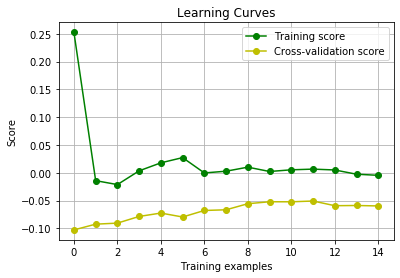

-------------------------------------------------------------


model:  SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
r2_score:  -4.32781446001919e+32


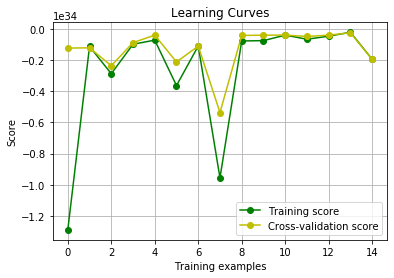

-------------------------------------------------------------


model:  BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)
r2_score:  0.004476241984762819


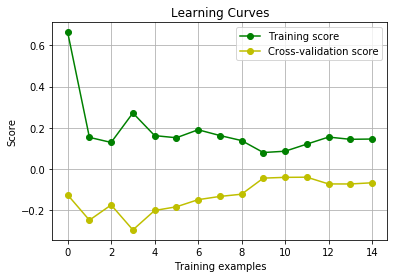

-------------------------------------------------------------


model:  LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)
r2_score:  -0.012926415947110304


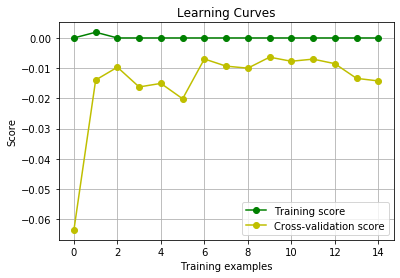

-------------------------------------------------------------


model:  ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, threshold_lambda=10000.0, tol=0.001,
              verbose=False)
r2_score:  0.2195358092289934


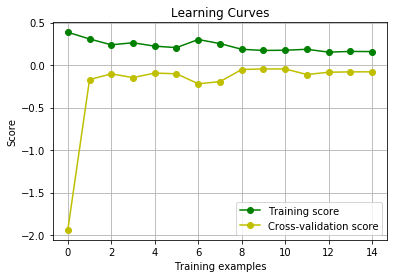

-------------------------------------------------------------


model:  PassiveAggressiveRegressor(C=1.0, average=False, early_stopping=False,
                           epsilon=0.1, fit_intercept=True,
                           loss='epsilon_insensitive', max_iter=1000,
                           n_iter_no_change=5, random_state=None, shuffle=True,
                           tol=0.001, validation_fraction=0.1, verbose=0,
                           warm_start=False)
r2_score:  -0.055199671774952996


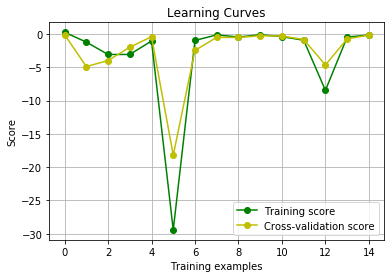

-------------------------------------------------------------


model:  TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
                  max_subpopulation=10000, n_jobs=None, n_subsamples=None,
                  random_state=None, tol=0.001, verbose=False)
r2_score:  -0.2604082898299134


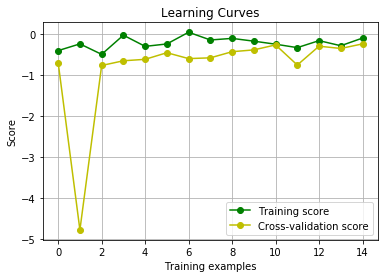

-------------------------------------------------------------


model:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
r2_score:  0.19875288985307915


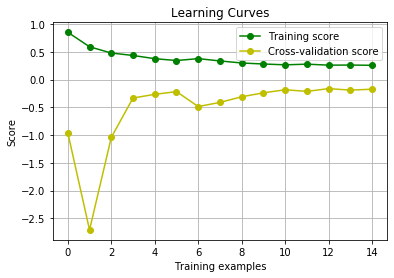

-------------------------------------------------------------


model:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
r2_score:  0.19875288985307948


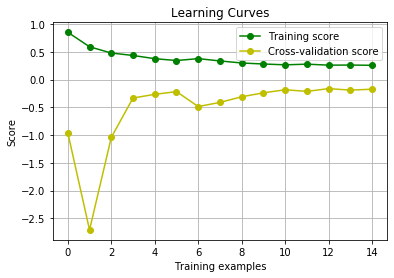

-------------------------------------------------------------




In [15]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# modeling
classifiers = [
    svm.SVR(gamma='auto'),
    linear_model.SGDRegressor(),
    linear_model.BayesianRidge(),
    linear_model.LassoLars(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.LinearRegression(normalize = False),
    linear_model.LinearRegression(normalize = True),
    #RandomForestRegressor(),
    #RandomForestRegressor(n_estimators = 200, max_depth = 40, min_samples_split = 10),
    #neural_network.MLPRegressor(hidden_layer_sizes = (716, 512, 2), learning_rate_init = 0.03),
    #neural_network.MLPRegressor(hidden_layer_sizes = (1024, 512, 2), learning_rate_init = 0.03, activation = 'logistic', max_iter=400),
    #neural_network.MLPRegressor(hidden_layer_sizes = (1024, 512, 2), learning_rate_init = 0.03)
    ]

trainingData    = X_train
trainingScores  = y_train
predictionData  = X_test

r2_list = []
for item in classifiers:
    clf = item
    clf.fit(trainingData, trainingScores.values.ravel())
    predictionScore = clf.predict(predictionData)
    r2 = r2_score(y_test,predictionScore)
    r2_list.append(r2)
    print('model: ',item)
    print('r2_score: ',r2)
    draw_learning_curves(trainingData, trainingScores.values.ravel(), item, 15)
    print('-------------------------------------------------------------\n\n')
    




Model with the best metric 

ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, threshold_lambda=10000.0, tol=0.001,
              verbose=False)
r2 score: 0.2195358092289934


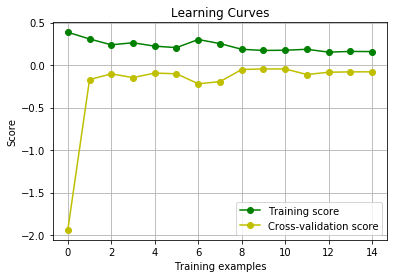

In [16]:
print('Model with the best metric \n')
    
model = classifiers[r2_list.index(max(r2_list))]
print(model)
print('r2 score:', max(r2_list))

draw_learning_curves(trainingData, trainingScores.values.ravel(), model, 15)

In [17]:
missing_vol = od_vol_missing_by_equip.loc[:,corr_feats]     

clf = model
clf.fit(trainingData, trainingScores.values.ravel())
predictionScore = clf.predict(missing_vol)

f = lambda x : x if x > 0 else 0

od_vol_missing_by_equip.loc[:,'vol'] = np.array([f(x) for x in predictionScore])
od_vol_missing_by_equip

C:\Users\alexa\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,fid,lid,vol,cost_f,domicilios,familias,populacao,matriculas,empregos,automoveis,...,atr_motivo_trabalho_industria,atr_motivo_trabalho_comercio,atr_motivo_trabalho_servcos,atr_motivo_educacao,atr_motivo_compras,atr_motivo_saude,atr_motivo_lazer,atr_motivo_procurar_emprego,atr_motivo_assuntos_pessoais,atr_motivo_refeicao
9190,10443,12011,11.128745,0.54,14938.0,14938.0,39440.0,8489.5,20774.8,17032.5,...,4522.5,14550.0,22238.7,25938.5,3117.6,2032.5,6557.6,281.8,1799.4,1240.6
9837,10443,11137,0.000000,1.45,21512.0,21512.0,70826.0,15195.5,17140.3,7552.9,...,6983.8,8127.1,29098.4,45352.7,3549.9,7641.5,847.7,465.2,2650.3,646.5
